In [2]:
import pandas as pd
import numpy as np

from plotnine import *

import statsmodels.formula.api as smf

from pandas_profiling import ProfileReport

import warnings

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("../data/cps-earnings/clean/morg-2014-emp.csv",index_col = 0)

In [40]:
data.columns

Index(['hhid', 'intmonth', 'stfips', 'weight', 'earnwke', 'uhours', 'grade92',
       'race', 'ethnic', 'age', 'sex', 'marital', 'ownchild', 'chldpres',
       'prcitshp', 'state', 'ind02', 'occ2012', 'class', 'unionmme',
       'unioncov', 'lfsr94'],
      dtype='object')

 Selecting:
 - Computer programmers 1010
 - Software developers, applications and systems software 1020
 - Web developers 1030

In [551]:
work = data.loc[lambda x: x["occ2012"].isin([1010,1020,1030])]

Dropping household id and month of questionary, (also the weight ?)

In [552]:
work = work.drop(["hhid","intmonth"],axis=1)

In [553]:
work.isnull().sum()

stfips         0
weight         0
earnwke        0
uhours         0
grade92        0
race           0
ethnic      1977
age            0
sex            0
marital        0
ownchild       0
chldpres       0
prcitshp       0
state          0
ind02          0
occ2012        0
class          0
unionmme       0
unioncov      55
lfsr94         0
dtype: int64

# 1. Feature engineering

## Target variable

In [554]:
work["w"] = work["earnwke"] / work["uhours"]
work["lnw"] = np.log(work["w"])

## Continous variables

### 1. age

In [555]:
work["agesq"] = np.power(work["age"], 2)

### 2. education

Calculate years spend in education to get experience

In [556]:
work["edu"] = work["grade92"]

In [557]:
work["edu"].value_counts().sort_index()

36       1
37       2
38       2
39      71
40     184
41      60
42      98
43    1098
44     505
45       9
46      37
Name: edu, dtype: int64

In [558]:
work["years_in_edu"] = work["edu"].map(
    {
        36: 10,
        37: 11,
        38: 12,
        39: 12,
        40: 13,
        41: 15,
        42: 15,
        43: 15,
        44: 17,
        45: 17,
        46: 22,
    }
)

## Categorical variables

### 0. create categorical from education

In [559]:
work["edu"] = np.where(
    work["edu"] < 43,
    "no degree",
    np.where(
        work["edu"] == 43,
        "BA degree",
        np.where((work["edu"] == 44) | (work["edu"] == 45), "MA degree", "Phd degree"),
    ),
)

In [560]:
work["edu"].value_counts()

BA degree     1098
MA degree      514
no degree      418
Phd degree      37
Name: edu, dtype: int64

### 1. race

In [561]:
work.race.value_counts()

1     1443
4      487
2       97
8       16
3        8
5        6
7        5
6        2
11       1
13       1
17       1
Name: race, dtype: int64

I decode race based on pdf as: 1:"white" 2:"black" 4:"asian" else:"other"

In [562]:
work["race"] = np.where(
    work["race"] == 1,
    "white",
    np.where(
        work["race"] == 2,
        "black",
        np.where(work["race"] == 4, "asian", "other"),
    ),
)

### 2. gender

In [563]:
work["sex"] = work.sex.map({1:"male",2:"female"})

### 3. marital

In [564]:
work.marital.value_counts().sort_index()

1    1306
2       4
3      35
4      13
5     133
6      24
7     552
Name: marital, dtype: int64

In [565]:
work["marital_status"] = np.where(
    work["marital"].isin([1, 2, 3]),
    "married",
    np.where(work["marital"].isin([4, 5, 6]), "used to be married", "never married"),
)

### 4. union

In [566]:
work["union"] = ((work["unionmme"] == "Yes") | (work["unioncov"] == "Yes")).astype(int)

### 5. children

In [567]:
work.ownchild.value_counts().sort_index()

0    1236
1     344
2     367
3      97
4      14
5       4
6       3
7       1
9       1
Name: ownchild, dtype: int64

In [568]:
work["n_children"] = np.where(work["ownchild"]>=3,"3>=",work["ownchild"].astype("str"))

### 6. employment status

In [569]:
work["emp_status"] = work.lfsr94

work.emp_status.value_counts()

Employed-At Work    2023
Employed-Absent       44
Name: emp_status, dtype: int64

### 7. class

In [570]:
work["working_class"] = work["class"]
work["working_class"].value_counts()

Private, For Profit     1796
Private, Nonprofit        92
Government - Federal      81
Government - State        74
Government - Local        24
Name: working_class, dtype: int64

### 8. occupation

In [571]:
work["occup"] = work["occ2012"]
work["occup"].value_counts()

1020    1335
1010     516
1030     216
Name: occup, dtype: int64

### 9. industry

In [572]:
work["industry"] = work["ind02"]

work["industry"] = np.where(
    work["industry"] == "Computer systems design and related services (5415)",
    "Computer systems design",
    "Other",
)

work["industry"].value_counts()

Other                      1340
Computer systems design     727
Name: industry, dtype: int64

### 10. state

Lof of states, probably won't use it.

In [573]:
work["state"] = work["stfips"]

### 11. non-USborn

In [574]:
work.prcitshp.value_counts()

Native, Born In US                        1445
Foreign Born, Not a US Citizen             323
Foreign Born, US Cit By Naturalization     263
Native, Born Abroad Of US Parent(s)         29
Native, Born in PR or US Outlying Area       7
Name: prcitshp, dtype: int64

In [575]:
work["nonUSborn"] = (
    (work["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (work["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

In [576]:
work_clean = work.filter(
    [
        "w",
        "lnw",
        "age",
        "agesq",
        "exp",
        "expsq",
        "sex",
        "race",
        "edu",
        "years_in_edu",
        "marital_status",
        "n_children",
        "union",
        "emp_status",
        "working_class",
        "occup",
        "industry",
        "nonUSborn",
    ]
)

### + addigional features

### experience



In [577]:
work_clean["exp"] = work_clean["age"] - work_clean["years_in_edu"] - 6
work_clean["expsq"] = work_clean["exp"]**2

In [578]:
work_clean[["age","exp"]].corr()

,age,exp
age,1.000000,0.989701
exp,0.989701,1.000000


This is a problem, will decide age vs exp to use.

# 2. Descriptive statistics

profile = ProfileReport(work, title="CPS-earnings", explorative=True)

profile.to_file("cps_report.html")

<AxesSubplot:>

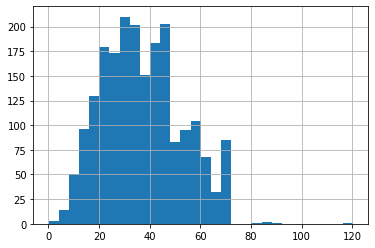

In [579]:
work.w.hist(bins=30)

In [580]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [581]:
from sklearn.model_selection import KFold
k = KFold(n_splits=4, shuffle=False, random_state=None)

In [582]:
def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []
    target = formula.split("~")[0].strip()

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]

        rmse_tr = pd.concat(
            [data_train[target], model.predict(data_train)],
            axis=1,
            keys=[target, "predicted"],
        )
        rmse_tr = rmse_tr[~rmse_tr.isna().any(axis=1)]

        rmse_te = pd.concat(
            [data_test[target], model.predict(data_test)],
            axis=1,
            keys=[target, "predicted"],
        )
        rmse_te = rmse_te[~rmse_te.isna().any(axis=1)]

        rmse_list += [rmse(rmse_tr[target], rmse_tr["predicted"], axis=0)]
        rmse_list_test += [rmse(rmse_te[target], rmse_te["predicted"], axis=0)]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }


def summarize_cv(cvlist, stat="rmse_test"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cvlist))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [605]:
target = "w"
continous = ["age", "agesq", "exp", "expsq"]

categorical = [
    "sex",
    "race",
    "edu",
    "marital_status",
    "n_children",
    "union",
    "emp_status",
    "working_class",
    "occup",
    "industry",
    "nonUSborn",
]

interactions = " + (edu + sex + race) * (marital_status  + n_children)"

In [606]:
cv1 = cv_reg(target + "~" + "age + agesq", work_clean, k, "HC0")
cv2 = cv_reg(target + "~" + "+".join(continous + categorical), work_clean, k, "HC0")
cv3 = cv_reg(
    target + "~" + "+".join(continous + categorical) + interactions,
    work_clean,
    k,
    "HC0",
)
cv4 = cv_reg(
    target
    + "~"
    + "+".join(continous + categorical)
    + "+("
    + "+".join(continous)
    + ")*("
    + "+".join(categorical)
    + ")",
    work_clean,
    k,
    "HC0",
)

In [607]:
cv_list = [cv1, cv2, cv3, cv4]
avg_rmse = summarize_cv(cv_list)

In [608]:
results = pd.DataFrame(
    {
        "rmse": avg_rmse.loc["Average", :],
        "nvars": [cv1["nvars"], cv2["nvars"], cv3["nvars"], cv4["nvars"]],
    }
)

(14.0, 15.4)

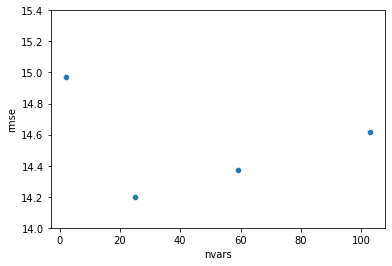

In [609]:
sns.scatterplot(results["nvars"], results["rmse"])
plt.ylim(14, 15.4)